In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os
import cv2


import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

# DEFINED
BATCH_SIZE = 32
IMG_WIDTH  = 224
IMG_HEIGHT = 224

%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Python Version:  3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version:  2.10.0


In [10]:
# Load model
model = keras.models.load_model("../TrainingModels/SelfBuild2.h5")

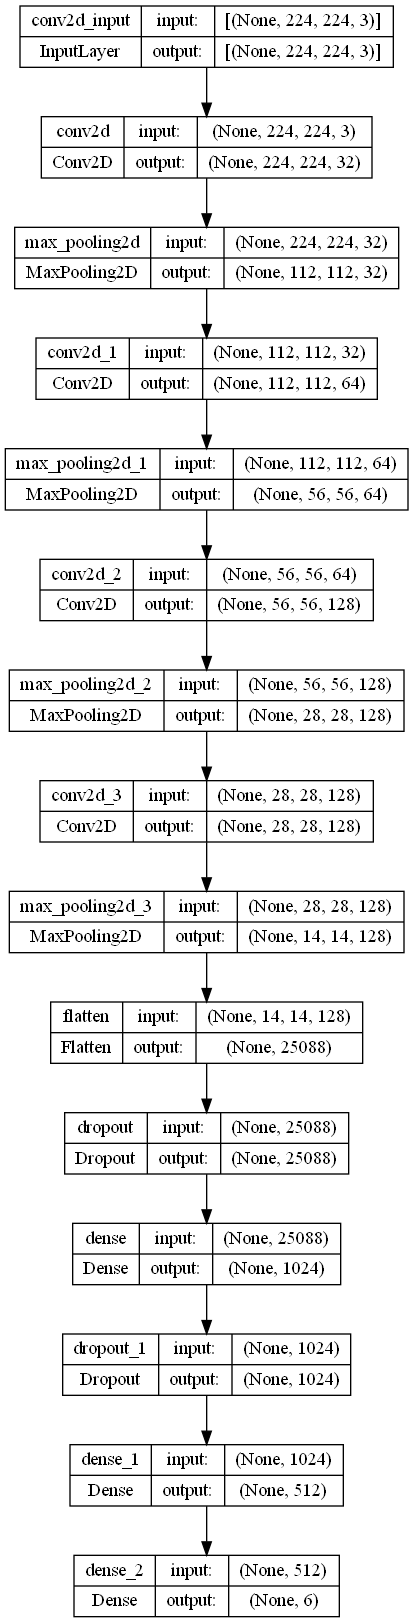

In [11]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)
# Also if you use Google Colab, it's not necessary to use these code

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


In [13]:
furniture_df = pd.read_csv("../furniture_data.csv")
shuffled_furniture_df = furniture_df.sample(frac=1).reset_index(drop=True)

# Print the DataFrame
shuffled_furniture_df.head()

,Furniture_Category,Furniture_Type,Image_Path
0,tables,Traditional,../Furniture_Data\tables\Traditional\16771trad...
1,chairs,Midcentury,../Furniture_Data\chairs\Midcentury\19813midce...
2,chairs,Traditional,../Furniture_Data\chairs\Traditional\9620tradi...
3,dressers,Traditional,../Furniture_Data\dressers\Traditional\2704tra...
4,tables,Beach,../Furniture_Data\tables\Beach\22735beach-styl...


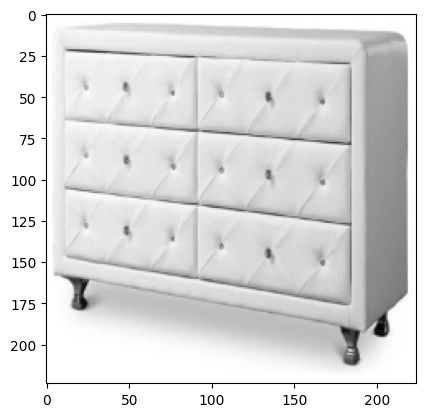

In [14]:
# Test dataset processing
def prepare(filepath):
    img_array = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return np.expand_dims(new_array, axis=0).repeat(BATCH_SIZE, axis=0)

img_test_list = []


# Add image for prediction testing before image processing
for i in range(25):
    first_data = shuffled_furniture_df.iloc[i]['Image_Path']
    # print(first_data)
    img_arr = prepare(first_data)
    img_test_list.append(img_arr)

# Check image after preprocess by using first image
plt.imshow(img_test_list[19][0])

Single Prediction in first data

In [15]:
categorical_folders = furniture_df["Furniture_Category"].unique()
categorical_folders

array(['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables'],
      dtype=object)

In [18]:
# Single predict
idx = 19
first_data = shuffled_furniture_df.iloc[idx]['Image_Path']
img_arr = prepare(first_data)

prediction = model.predict(img_arr)
predicted_class_index = np.argmax(prediction, axis=1)


# Use the index to get the corresponding class label from categorical_folders
predicted_class_label = categorical_folders[predicted_class_index[0]]

print('Predict: ' + predicted_class_label)
print('Actual: ' + shuffled_furniture_df.iloc[idx]['Furniture_Category'])


1/1 [==============================] - 0s 280ms/step
Predict: dressers
Actual: dressers


1/1 [==============================] - 0s 272ms/step


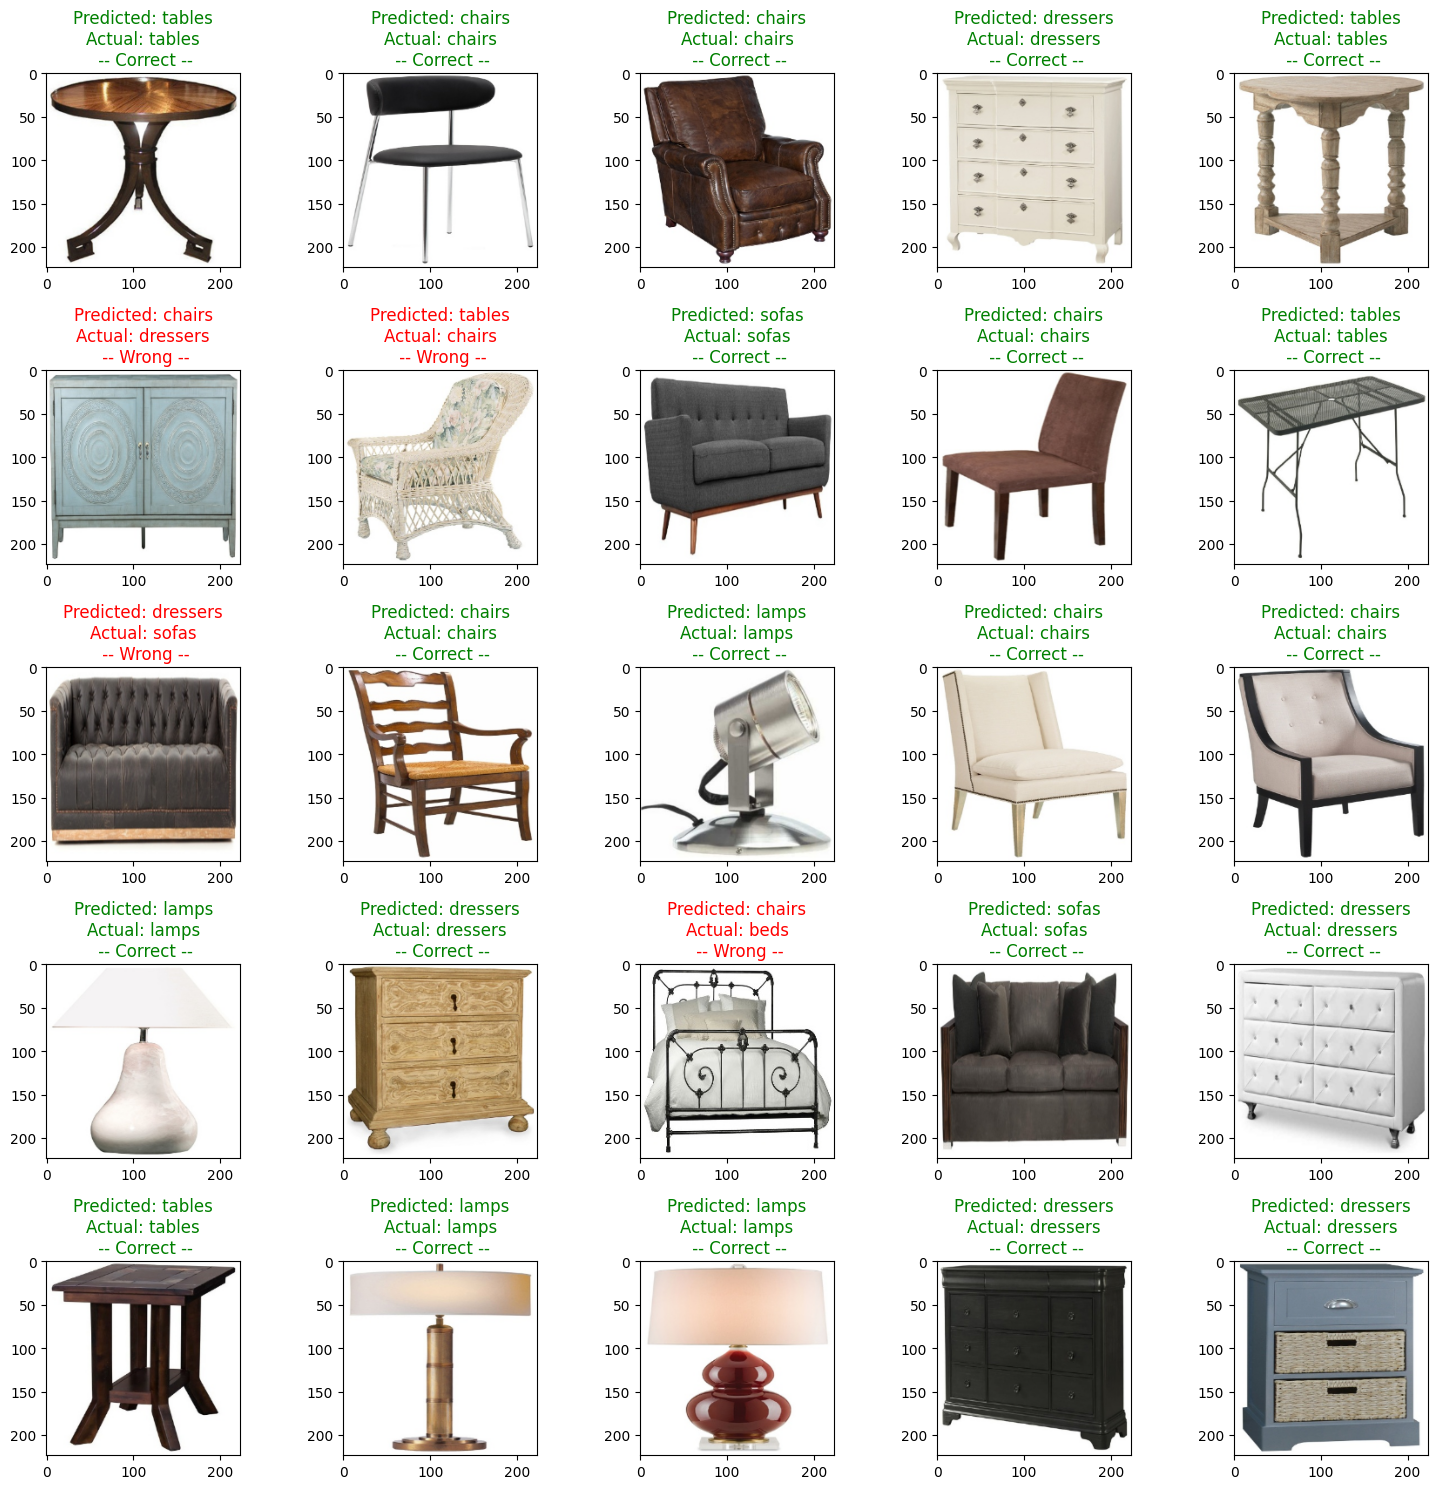

In [17]:
#  Multiple prediction using image table
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

predicted_result = []
for i in range(25):
    prediction = model.predict(img_test_list[i])
    predicted_class_index = np.argmax(prediction, axis=1)

    # Use the index to get the corresponding class label from categorical_folders
    predicted_class_label = categorical_folders[predicted_class_index[0]]
    predicted_result.append(predicted_class_label)

for i, ax in enumerate(axes.flat):
    ax.imshow(img_test_list[i][0])

    color = 'white'
    if predicted_result[i] == shuffled_furniture_df.loc[i, 'Furniture_Category']:
        color = 'green'
    else:
        color = 'red'

    def correct_wrong_predicted(item01, item02):

        if item01 == item02:
            return "Correct"
        else:
            return "Wrong"
        
        

    ax.set_title('Predicted: {}'.format(predicted_result[i]) +  
                 '\nActual: ' + shuffled_furniture_df.loc[i, 'Furniture_Category'] + 
                 '\n -- {} --'.format(correct_wrong_predicted(predicted_result[i], shuffled_furniture_df.loc[i, 'Furniture_Category'])), color=color )
plt.tight_layout()
plt.show()